## Import maskrcnn model 

In [2]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import surgAR_load_cylind

# add configuration 
config = surgAR_load_cylind.CustomConfig()
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.90

config = InferenceConfig()
config.display()

model = modellib.MaskRCNN(mode="inference", model_dir='/home/mahmoud/Desktop/Mask_RCNN/logs', config=config)
modelbalanced = '/home/mahmoud/Desktop/Mask_RCNN/logs/balanced/balancedmodel_withoutAug_77mAP/object20210603T0040/mask_rcnn_object_0100.h5'
model.load_weights(modelbalanced, by_name=True)

# Dataset 
# Load validation dataset
TOOL_DATA_DIR = '/home/mahmoud/Desktop/Mask_RCNN/samples/Tool/dataset'
dataset = surgAR_load_cylind.CustomDataset()
dataset.load_custom(TOOL_DATA_DIR, "val")

# Must call before using the dataset
dataset.prepare()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Import ART-Net

In [6]:
from tensorflow.keras.models import model_from_yaml
import tensorflow as tf

# configure gpu
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#-----------------------------------Create ART-Net Model----------------------------------------------------

# Load (Read) the model which saved as yaml file. 
yaml_file = open('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Jupyter/modelSaved.yaml', 'r')  
# "modelSaved.yaml" is the file name and should be in the same directory of this notebook script. 

loaded_model_yaml = yaml_file.read()
yaml_file.close()
modelArt = model_from_yaml(loaded_model_yaml)
modelArt.load_weights('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/FullTraining/ModelLR1/newExtra30-6_lossweight.h5')


## Extract Primitives from ART-Net predictions

In [34]:
import numpy as np 
import os
import glob
import cv2
import glob
import itertools
from skimage.morphology import skeletonize
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
from math import atan2,degrees, atan
from mpl_toolkits.mplot3d import Axes3D
from skimage.morphology import skeletonize
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from matplotlib import cm
from shapely.geometry import LineString
from shapely.geometry import Point
from sympy import *
import math
from sympy.geometry import *
from skimage.measure import label, regionprops
from scipy.spatial import distance
from skimage.morphology import disk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import precision_score, accuracy_score, roc_curve, auc
from skimage.transform import resize 


def slope_intercept(xi, yi, xf, yf):
    '''
    This function is dedicated for calculating the slope of the line. 
    
    Input Arguments: 
         xi: The initial X co-ordinate
         yi: The initial Y co-ordinate
         xf: The final X co-ordinate
         yf: The final Y co-ordinate
         
    Output Arguments:
        slope: Slope of the st. line connecting those two points
        intercept: The intersecting length from Y-axis
         
    Author: Md. Kamrul Hasan, 
        Erasmus Scholar on Medical Imaging and Application (MAIA)
        E-mail: kamruleeekuet@gmail.com
        
    '''
    
    slope = (yf - yi) / (xf - xi)
    intercept = yi - slope * xi 
    
    return slope,intercept

def Angular_Displacement(height, width, L1x1, L1y1, L1x2, L1y2, L2x1, L2y1, L2x2, L2y2):
    '''
    This code is for calculating Angular Displacement between a pair of lines.
    The predicted edge and mid line features can be evaluated quantitatively using the mean angular 
    displacement (mAD) error from the center of the image frame between the true andpredicted line.
    Angular displacement is calculated by the arc length distance between true point and predicted point.
    More details explanations of this metric see the paper please. 
    
    Input Arguments: 
        height = Height of the Image
        width  = Width of the Image
        L1x1 =  Initial X co-ordinate of the first line
        L1y1 =  Initial Y co-ordinate of the first line
        L1x2 =  Final X co-ordinate of the first line
        L1y2 =  Final Y co-ordinate of the first line
        L2x1 =  Initial X co-ordinate of the second line
        L2y1 =  Initial Y co-ordinate of the second line
        L2x2 =  Final X co-ordinate of the second line
        L2y2 =  Final Y co-ordinate of the second line
        
    Output Arguments:  
    
        AngularDisplacement: The average Angular Displacement of left and right side Displacement.
        
    Author: Md. Kamrul Hasan, 
        Erasmus Scholar on Medical Imaging and Application (MAIA)
        E-mail: kamruleeekuet@gmail.com
        
    '''

    center_x = int(height/2)
    center_y = int(width/2)
    centerPoint = Point(center_x,center_y)
    radius = np.sqrt((center_x)**2+(center_y)**2)

    circle = Circle(centerPoint, radius)

    lineApprox = Line((L1x1,L1y1),(L1x2,L1y2))
    lineTrue = Line((L2x1,L2y1),(L2x2,L2y2))

    intersectionApprox= intersection(circle, lineApprox)
    intersectionTrue= intersection(circle, lineTrue)

    intXY1P = intersectionApprox[0].evalf()
    X_P_1 = intXY1P.x
    Y_P_1 = intXY1P.y
#         print(X_P_1)
#         print(Y_P_1)

    intXY2P = intersectionApprox[1].evalf()
    X_P_2 = intXY2P.x
    Y_P_2 = intXY2P.y
#         print(X_P_2)
#         print(Y_P_2)


    intXY1G = intersectionTrue[0].evalf()
    X_G_1 = intXY1G.x
    Y_G_1 = intXY1G.y
#         print(X_G_1)
#         print(Y_G_1)


    intXY2G = intersectionTrue[1].evalf()
    X_G_2 = intXY2G.x
    Y_G_2 = intXY2G.y
#         print(X_G_2)
#         print(Y_G_2)

    slope1_P, intercept=slope_intercept(X_P_1, Y_P_1, center_x, center_y)
    slope1_G, intercept=slope_intercept(X_G_1, Y_G_1, center_x, center_y)

    slope2_P, intercept=slope_intercept(X_P_2, Y_P_2, center_x, center_y)
    slope2_G, intercept=slope_intercept(X_G_2, Y_G_2, center_x, center_y)

#         print(slope1_P)
#         print(slope1_G)
#         print(slope2_P)
#         print(slope2_G)

    theta_1=atan(abs((slope1_P-slope1_G)/(1+slope1_G*slope1_P)))
    theta_2=atan(abs((slope2_P-slope2_G)/(1+slope2_G*slope2_P)))
    
    AngularDisplacement=(theta_1+theta_2)/2
    
    return AngularDisplacement


#...........................Edge lines.............................................................
def edgeLinesM(orimg, imgPred, i, original_image):
    # convert to uint8 if the image is float
    orimg = orimg.astype(np.uint8)
    imgPredtemp=imgPred.copy()

    #imgPred = mask.copy() 
    #orimg = image.copy()
    orimg = cv2.resize(orimg,(256,192))
    path = '/home/mahmoud/Desktop/primitives' 
    
    # save original image 
    cv2.imwrite(path+'/image{:04d}'.format(i)+'.png', original_image)

    #-----------------------Truncate the intensity lower than Threshold--------------------------
    Threshold = (imgPred.max())-100
    imgPred[imgPred<Threshold]=0
    imgPredtemp[imgPredtemp<Threshold-30]=0

    #-----------------------Classic straight-line Hough transform-------------------------------
    h, theta, d = hough_line(imgPred)        
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=9, min_angle=10, threshold=0.5*h.max(), num_peaks=1)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - imgPred.shape[1] * np.cos(angle)) / np.sin(angle)
    x0P1 = 0
    y0P1 = int(y0)
    x1P1 = imgPred.shape[1]
    y1P1 = int(y1)

    #-------------------------Approximate Line_1------------------------------------------------
    ApproximateLine1=np.zeros_like(imgPred, dtype=np.uint8)

    cv2.line(ApproximateLine1,(x0P1,y0P1),(x1P1,y1P1), 255, 1)       

    #------------------------Classic straight-line Hough transform------------------------------
    temp=np.zeros_like(imgPred, dtype=np.uint8)
    temp=cv2.line(temp,(x0P1,y0P1),(x1P1,y1P1), 255, 15)

    temp = 255-temp

    imgPred=imgPred & temp

    h, theta, d = hough_line(imgPred)        
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=9, min_angle=10, threshold=0.5*h.max(), num_peaks=1)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - imgPred.shape[1] * np.cos(angle)) / np.sin(angle)
    x0P2 = 0
    y0P2 = int(y0)
    x1P2 = imgPred.shape[1]
    y1P2 = int(y1)

    #-------------------------Approximate Line_2------------------------------------------------
    ApproximateLine2=np.zeros_like(imgPred, dtype=np.uint8)

    cv2.line(ApproximateLine2,(x0P2,y0P2),(x1P2,y1P2), 255, 1)

    ApproximateLine = ApproximateLine2 + ApproximateLine1

    #cv2.imwrite(path+'/mask_{}'.format(i)+'_Line_1_.png',ApproximateLine1) 
    #cv2.imwrite(path+'/mask_{}'.format(i)+'_Line_2_.png',ApproximateLine2) 
    ApproximateLine1 = cv2.resize(ApproximateLine1,(1280,720))
    ApproximateLine2 = cv2.resize(ApproximateLine2,(1280,720))
    cv2.imwrite(path+'/image{:04d}'.format(i)+'_edgeLine.png',ApproximateLine1 + ApproximateLine2) 
    cv2.imwrite(path+'/image{:04d}'.format(i)+'_edgeLine_Line_1_.png',ApproximateLine1) 
    cv2.imwrite(path+'/image{:04d}'.format(i)+'_edgeLine_Line_2_.png',ApproximateLine2) 
    
    print(ApproximateLine1.dtype)


    #-------------------Overlay with original Image and same to path-------------------------------       
    temp = cv2.merge((ApproximateLine, ApproximateLine, ApproximateLine))
    temp [:,:,0]=0
    temp [:,:,2]=0  
    temp = cv2.resize(temp,(1280,720))
    original_image = cv2.resize(original_image,(1280,720))

    dummy1 = cv2.addWeighted(temp,0.99,original_image,0.8,0)
    cv2.imwrite(path+'/image_overlay_{}'.format(i)+'_Lines_.png',dummy1) 
    #plt.imshow(dummy1)
    #plt.show()
    return dummy1
    
def tipPointM(orimg, imgPred, i, original_image):
    # case 
    orimg = orimg.astype(np.uint8)
    imgPredtemp=imgPred.copy()
    
    # maskrcnn
    #imgPred = mask.copy() 
    #imgPredtemp=imgPred.copy()
    #orimg = imgIndv.copy()
    
    orimg = cv2.resize(orimg,(256,192))
    path = '/home/mahmoud/Desktop/primitives'

    #cv2.imwrite(path+'/image{:04d}'.format(i)+'.png', original_image)

    # save original image 
    cv2.imwrite(path+'/image{:04d}'.format(i)+'.png', original_image)
    
    #......................................... Tool Tip .....................................................

    #----------------------Truncate the intensity lower than Threshold-----------------------
    Threshold = (imgPred.max())-100
    imgPred[imgPred<Threshold]=0

    #-----------------------Overlay with original Image--------------------------------------       
    temp = cv2.merge((imgPred, imgPred, imgPred))
    temp [:,:,0]=0
    temp [:,:,2]=0
    temp = cv2.resize(temp,(1280,720))
    #cv2.imwrite(path+'/mask_{}'.format(i)+'_tip.png',temp) 
    cv2.imwrite(path+'/image{:04d}'.format(i)+'_tipPoint_Approximated.png',temp)
    dummy = cv2.addWeighted(temp, 0.8, original_image, 0.8, 0)        
    cv2.imwrite(path+'/image_overlay_{}'.format(i)+'_tip.png',dummy) 
    plt.imshow(dummy)
    plt.show()
    




def midLineM(orimg, imgPred, i, original_image):
    # case 
    orimg = orimg.astype(np.uint8)
    imgPredtemp=imgPred.copy()
    # maskrcnn
    #imgPred = mask.copy() 
    #imgPredtemp=imgPred.copy()
    #orimg = imgIndv.copy()
    orimg = cv2.resize(orimg,(256,192))
    path = '/home/mahmoud/Desktop/primitives'
    
    # save original image 
    cv2.imwrite(path+'/image{:04d}'.format(i)+'.png', original_image)
    
    # read GT mid line
    #trueLine = cv2.imread(OriginalMidlineGT,0)
    #trueLine = cv2.resize(trueLine,(256,192))
    
    #-------------------------------Truncate the intensity lower than Threshold----------------------
    Threshold = (imgPred.max())-100
    imgPred[imgPred<Threshold]=0

    temp = cv2.merge((imgPredtemp, imgPredtemp, imgPredtemp))
    temp [:,:,0]=0
    temp [:,:,2]=0 
    
    savelinePath=path+'ImgID_'+'mid'+'_Prediction_.png'
    #cv2.imwrite(savelinePath,cv2.addWeighted(temp,0.99,orimg,0.8,0))


    #-----------------------------Classic straight-line Hough transform----------------------------
    h, theta, d = hough_line(imgPred)        
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=9, min_angle=10, threshold=0.5*h.max(), num_peaks=1)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - imgPred.shape[1] * np.cos(angle)) / np.sin(angle)
    x0P = 0
    y0P = int(y0)
    x1P = imgPred.shape[1]
    y1P = int(y1)
    #-----------------------------Approximate Line-------------------------------------------------
    ApproximateLine=np.zeros_like(imgPred, dtype=np.uint8)

    cv2.line(ApproximateLine,(x0P,y0P),(x1P,y1P), 255, 1)

    #-----------------------Overlay with original Image------------------------------------------       
    temp = cv2.merge((ApproximateLine, ApproximateLine, ApproximateLine))
    temp [:,:,0]=0
    temp [:,:,2]=0 
    temp = cv2.resize(temp,(1280,720))
    original_image = cv2.resize(original_image,(1280,720))
    mid = cv2.addWeighted(temp,0.99,original_image,0.8,0)
    #cv2.imwrite(path+'/mask_{}'.format(i)+'_midLine.png',ApproximateLine) 
    ApproximateLine = cv2.resize(ApproximateLine,(1280,720))
    cv2.imwrite(path+'/image{:04d}'.format(i)+'_midLine.png',ApproximateLine) 
    cv2.imwrite(path+'/image_overlay_{}'.format(i)+'_midLine.png',mid) 
    plt.imshow(mid)
    plt.show()
    
    
    

def midlineEvaluateSeparate(orimg, OriginalMidlineGT, imgPred, i):
    #------------------------------------Read the Prediction from SIMO--------------------------------
    orimg = orimg.astype(np.uint8)
    orimg = orimg.copy()
    tempimgPred = imgPred.copy()
    #-----------------------------------Read Original Image with Midline GT---------------------------
    #orimg = cv2.imread(OriginalImage[i],-1)
    #orimg = cv2.resize(orimg,(256,192))

    trueLine = cv2.imread(OriginalMidlineGT,0)
    trueLine = cv2.resize(trueLine,(256,192))
    i=i+1
    #-------------------------------Truncate the intensity lower than Threshold----------------------
    Threshold = (imgPred.max())-100
    imgPred[imgPred<Threshold]=0

    temp = cv2.merge((tempimgPred, tempimgPred, tempimgPred))
    temp [:,:,0]=0
    temp [:,:,2]=0 


    #savelinePath=midlinesavePath+'ImgID_'+filename[-11:]+'_Prediction_.png'
    #cv2.imwrite(savelinePath,cv2.addWeighted(temp,0.99,orimg,0.8,0))
    midlinesavePath = '/home/mahmoud/Desktop/primitives/'

    #-----------------------------Classic straight-line Hough transform----------------------------
    h, theta, d = hough_line(imgPred)        
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=9, min_angle=10, threshold=0.5*h.max(), num_peaks=1)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - imgPred.shape[1] * np.cos(angle)) / np.sin(angle)
    x0P = 0
    y0P = int(y0)
    x1P = imgPred.shape[1]
    y1P = int(y1)

    #-----------------------------Approximate Line-------------------------------------------------
    ApproximateLine=np.zeros_like(imgPred, dtype=np.uint8)

    cv2.line(ApproximateLine,(x0P,y0P),(x1P,y1P), 255, 1)
        
    # savelinePath=midlinesavePath+filename[-11:]+'_Approx_.png'
    # cv2.imwrite(savelinePath,ApproximateLine)  
        
    #---------------------------True Line approximation----------------------------------------------
    h, theta, d = hough_line(trueLine)        
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=9, min_angle=10, threshold=0.5*h.max(), num_peaks=1)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - imgPred.shape[1] * np.cos(angle)) / np.sin(angle)
    x0G = 0
    y0G = int(y0)
    x1G= imgPred.shape[1]
    y1G= int(y1)

    trueLine=np.zeros_like(trueLine, dtype=np.uint8)

    cv2.line(trueLine,(x0G,y0G),(x1G,y1G), 255, 1)   


    #-----------------------Overlay with original Image------------------------------------------       
    temp = cv2.merge((ApproximateLine, ApproximateLine, ApproximateLine))
    temp [:,:,0]=0
    temp [:,:,2]=0 

    temp2 = cv2.merge((trueLine, trueLine, trueLine))
    temp2 [:,:,0]=0 


    dummy = cv2.addWeighted(temp,0.99,orimg,0.8,0)

    dummy = cv2.addWeighted(temp2,0.99,dummy,0.8,0)


    #----------------------mean Angular Displacement Error Measurements--------------------------

    AngularDisplacement=Angular_Displacement(height = 192,
                                            width = 256,
                                            L1x1 = x0P,
                                            L1y1 = y0P,
                                            L1x2 = x1P,
                                            L1y2 = y1P,
                                            L2x1 = x0G,
                                            L2y1 = y0G,
                                            L2x2 = x1G,
                                            L2y2 = y1G)
    
    print('ImageID_{}: '.format(i) +'  AD in radian: ' + str(AngularDisplacement)
              + '  AD in degrees: ' + str(degrees(AngularDisplacement)))
        
        
    #------------------------ApproximateLine with True Line---------------------------------------

    TruePlusApproximation = ApproximateLine+trueLine

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (80,185)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(dummy,str(round (degrees(AngularDisplacement),2)), 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    #         savelinePath=midlinesavePath+filename[-11:]+'_ApproxPlusTrue_.png'
    #         cv2.imwrite(savelinePath,TruePlusApproximation) 

    savelinePath=midlinesavePath+'ImgID_{}'.format(i)+'_Overlay_with_Approx_true_.png'
    cv2.imwrite(savelinePath,dummy) 
    
    
def edgeLinesEvaluateSeparate(orimg, OriginalupGT, OriginallowGT, imgPred, i):
        edgelinesavePath = '/home/mahmoud/Desktop/primitives/'
        AngularDisplacement_Line_1 = []
        AngularDisplacement_Line_2 = []
        bothError=[]
    #--------------------------Read the Prediction from SIMO----------------------------------------
        #imgPred = cv2.imread(Pred,0)
        temp = imgPred.copy()
        temp2 = imgPred.copy()
        
        #-------------------------Read Original Image with Midline GT-----------------------------------
        #orimg = cv2.imread(OriginalImage[i],-1)
        #orimg = cv2.resize(orimg,(256,192))
        orimg = orimg.astype(np.uint8)
        orimg = orimg.copy()
        
        up = cv2.imread(OriginalupGT,0)
        up = cv2.resize(up,(256,192))
        
        up[up<100]=0
        up[up>100]=255
        
        low = cv2.imread(OriginallowGT,0)
        low = cv2.resize(low,(256,192))
        low[low<100]=0
        low[low>100]=255
        
        trueline=up+low
        
        i=i+1

        #-----------------------Truncate the intensity lower than Threshold--------------------------
        imgPredtemp=imgPred.copy()
        
        Threshold = (imgPred.max())-100
        imgPred[imgPred<Threshold]=0
        imgPredtemp[imgPredtemp<Threshold-30]=0
        
        
        
#         savelinePath=midlinesavePath+filename[-13:]+'_Pred_.png'
#         cv2.imwrite(savelinePath,imgPred)
        
#         savelinePath=midlinesavePath+filename[-13:]+'_true_.png'
#         cv2.imwrite(savelinePath,trueline)
        
#         savelinePath=midlinesavePath+filename[-13:]+'_truePLUSPred_.png'
#         cv2.imwrite(savelinePath,trueline+imgPred)
                
        
        #-----------------------Classic straight-line Hough transform-------------------------------
        h, theta, d = hough_line(imgPred)        
        for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=9, min_angle=10, threshold=0.5*h.max(), num_peaks=1)):
            y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
            y1 = (dist - imgPred.shape[1] * np.cos(angle)) / np.sin(angle)
        x0P1 = 0
        y0P1 = int(y0)
        x1P1 = imgPred.shape[1]
        y1P1 = int(y1)
        
        #-------------------------Approximate Line_1------------------------------------------------
        ApproximateLine1=np.zeros_like(imgPred, dtype=np.uint8)
    
        cv2.line(ApproximateLine1,(x0P1,y0P1),(x1P1,y1P1), 255, 1)       
        
        #------------------------Classic straight-line Hough transform------------------------------
        temp=np.zeros_like(imgPred, dtype=np.uint8)
        temp=cv2.line(temp,(x0P1,y0P1),(x1P1,y1P1), 255, 15)
        
        temp = 255-temp
        
        imgPred=imgPred & temp
        
        h, theta, d = hough_line(imgPred)        
        for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=9, min_angle=10, threshold=0.5*h.max(), num_peaks=1)):
            y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
            y1 = (dist - imgPred.shape[1] * np.cos(angle)) / np.sin(angle)
        x0P2 = 0
        y0P2 = int(y0)
        x1P2 = imgPred.shape[1]
        y1P2 = int(y1)
        
        #-------------------------Approximate Line_2------------------------------------------------
        ApproximateLine2=np.zeros_like(imgPred, dtype=np.uint8)
    
        cv2.line(ApproximateLine2,(x0P2,y0P2),(x1P2,y1P2), 255, 1)
        
        ApproximateLine = ApproximateLine2 + ApproximateLine1
        

        #cv2.imwrite(midlinesavePath+filename[-13:]+'_Line_1_.png',ApproximateLine1) 
        #cv2.imwrite(midlinesavePath+filename[-13:]+'_Line_2_.png',ApproximateLine2) 
        
        
        #-----------------------True Line-1 approximation------------------------------------------
        h, theta, d = hough_line(trueline)        
        for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=9, min_angle=10, threshold=0.5*h.max(), num_peaks=1)):
            y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
            y1 = (dist - imgPred.shape[1] * np.cos(angle)) / np.sin(angle)
        x0G1 = 0
        y0G1 = int(y0)
        x1G1= imgPred.shape[1]
        y1G1= int(y1)
        
        up=np.zeros_like(trueline, dtype=np.uint8)
    
        cv2.line(up,(x0G1,y0G1),(x1G1,y1G1), 255, 1)  
        
        temp=np.zeros_like(trueline, dtype=np.uint8)
    
        cv2.line(temp,(x0G1,y0G1),(x1G1,y1G1), 255, 15) 
        temp = 255-temp
        
        trueline= trueline & temp
        
        labelImage=label(trueline)
        regions=regionprops(labelImage)
        Area=[]
        for region in range(len(regions)):
            maxThreshold=regions[region].area,
            Area.append(maxThreshold)
        X= sorted( [(x,i) for (i,x) in enumerate(Area)], reverse=True )[:2]

        index=np.array(X)
        V=index.T[1].tolist()
        trueline[labelImage!=(V[0]+1)]=0
        
        h, theta, d = hough_line(trueline)        
        for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=9, min_angle=10, threshold=0.5*h.max(), num_peaks=1)):
            y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
            y1 = (dist - imgPred.shape[1] * np.cos(angle)) / np.sin(angle)
        x0G2 = 0
        y0G2 = int(y0)
        x1G2= imgPred.shape[1]
        y1G2= int(y1)
        
        low=np.zeros_like(trueline, dtype=np.uint8)
    
        cv2.line(low,(x0G2,y0G2),(x1G2,y1G2), 255, 1)   
        
        trueline = up+low

#         savelinePath=midlinesavePath+filename[-13:]+'_ApproxPLUStrue_.png'
#         cv2.imwrite(savelinePath,ApproximateLine+trueline) 
        
        #-------------------Overlay with original Image-------------------------------       
        temp = cv2.merge((ApproximateLine, ApproximateLine, ApproximateLine))
        temp [:,:,0]=0
        temp [:,:,2]=0  
        
        temp1 = cv2.merge((trueline, trueline, trueline))
        temp1 [:,:,0]=0

        
        dummy1 = cv2.addWeighted(temp,0.99,orimg,0.8,0)
        dummy2 = cv2.addWeighted(temp1,0.99,dummy1,0.8,0)
        
#         savelinePath=midlinesavePath+filename[-13:]+'_overlay_.png'
#         cv2.imwrite(savelinePath,dummy2) 
        
        
        AngularDisplacement_approx1_up=Angular_Displacement(height = 192,
                                                            width = 256,
                                                            L1x1 = x0P1,
                                                            L1y1 = y0P1,
                                                            L1x2 = x1P1,
                                                            L1y2 = y1P1,
                                                            L2x1 = x0G1,
                                                            L2y1 = y0G1,
                                                            L2x2 = x1G1,
                                                            L2y2 = y1G1)
        
        AngularDisplacement_approx1_low=Angular_Displacement(height = 192,
                                                            width = 256,
                                                            L1x1 = x0P1,
                                                            L1y1 = y0P1,
                                                            L1x2 = x1P1,
                                                            L1y2 = y1P1,
                                                            L2x1 = x0G2,
                                                            L2y1 = y0G2,
                                                            L2x2 = x1G2,
                                                            L2y2 = y1G2)
        
        AngularDisplacement_approx2_up=Angular_Displacement(height = 192,
                                                            width = 256,
                                                            L1x1 = x0P2,
                                                            L1y1 = y0P2,
                                                            L1x2 = x1P2,
                                                            L1y2 = y1P2,
                                                            L2x1 = x0G1,
                                                            L2y1 = y0G1,
                                                            L2x2 = x1G1,
                                                            L2y2 = y1G1)
        
        AngularDisplacement_approx2_low=Angular_Displacement(height = 192,
                                                            width = 256,
                                                            L1x1 = x0P2,
                                                            L1y1 = y0P2,
                                                            L1x2 = x1P2,
                                                            L1y2 = y1P2,
                                                            L2x1 = x0G2,
                                                            L2y1 = y0G2,
                                                            L2x2 = x1G2,
                                                            L2y2 = y1G2)
        
        if AngularDisplacement_approx1_up>AngularDisplacement_approx1_low:
            line_1_Error = AngularDisplacement_approx1_low
        else:
            line_1_Error = AngularDisplacement_approx1_up
    
        AngularDisplacement_Line_1.append(line_1_Error)
        
        if AngularDisplacement_approx2_up>AngularDisplacement_approx2_low:
            line_2_Error = AngularDisplacement_approx2_low
        else:
            line_2_Error = AngularDisplacement_approx2_up
    
        AngularDisplacement_Line_2.append(line_2_Error)

        Error= (line_1_Error+line_2_Error)/2
        
        bothError.append(Error)
        
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (80,185)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2

        cv2.putText(dummy2,str(round(degrees(Error),2)), 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType)
        savelinePath=edgelinesavePath+'ImgID_{}'.format(i) + '_Pred_True-EdgeLine.png'
        cv2.imwrite(savelinePath,dummy2) 
        
        print('Angular Displacement (AD) in radian: '+ str(Error)
              + '  Angular Displacement (AD) in degrees: ' + str(degrees(Error)))

def tipPointEvaluateSeparate(orimg, OriginaltipGT, imgPred, i):
    tipsavePath = '/home/mahmoud/Desktop/primitives/'
    Euclidean_Tip=[]

    #--------------------------Read the Prediction from SIMO----------------------------------
    #imgPred = cv2.imread(Pred,0)
    temp = imgPred.copy()

    #-------------------------Read Original Image with TIP GT---------------------------------
    orimg = orimg.astype(np.uint8)
    orimg = orimg.copy()

    truepoint = cv2.imread(OriginaltipGT,0)
    truepoint = cv2.resize(truepoint,(256,192))
    i=i+1

    #----------------------Truncate the intensity lower than Threshold-----------------------
    Threshold = (imgPred.max())-100
    imgPred[imgPred<Threshold]=0

#         savelinePath=tipsavePath+filename[-7:]+'_Pred_.png'
#         cv2.imwrite(savelinePath,imgPred)

    #-----------------------Overlay with original Image--------------------------------------       
    temp = cv2.merge((imgPred, imgPred, imgPred))
    temp [:,:,0]=0
    temp [:,:,2]=0   

    temp2 = cv2.merge((truepoint, truepoint, truepoint))
    temp2 [:,:,0]=0

    dummy = cv2.addWeighted(temp, 0.8, orimg, 0.8, 0)
    dummy = cv2.addWeighted(temp2, 0.8, dummy, 0.8, 0)


    #------------------------Euclidean Distance-----------------------------------------------
    XY_PredictedPoint = np.argwhere(imgPred.max() == imgPred)
    XY_truePoint = np.argwhere(truepoint.max() == truepoint)

    X_P = XY_PredictedPoint[0][1]
    Y_P = XY_PredictedPoint[0][0]

    X_G = XY_truePoint[0][1]
    Y_G = XY_truePoint[0][0]  

    euclidean_distance = distance.euclidean((X_P, Y_P), (X_G, Y_G))
    print('ImageID_{}: '.format(i)+ '.   Euclidean Distance in pixels: '+ str(euclidean_distance))
    Euclidean_Tip.append(euclidean_distance)

    #--------------------Approximate point with True point---------------------------------------

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (80,185)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(dummy,str(round(euclidean_distance,2)), 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    savelinePath=tipsavePath+'ImgID_{}'.format(i) + '_Overlay_Pred_True.png'
    cv2.imwrite(savelinePath,dummy)


## Extract frames 

In [ ]:
import cv2 
import os
import matplotlib.pyplot as plt



path = '/home/mahmoud/Desktop/trocar_estimation_adrien/liver_tools_trocars_compressed.avi'
pathSave = '/home/mahmoud/Desktop/trocar_estimation_adrien/frames_singletool'

# # Plotting dependency 
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


cap= cv2.VideoCapture(path)
i=0
while(cap.isOpened()):
  ret, image = cap.read()
  if ret == False:
      break
  # Load image
    #image = skimage.io.imread(path3)

  # If grayscale. Convert to RGB for consistency.
  if image.ndim != 3:
        image = skimage.color.gray2rgb(image)

  # If has an alpha channel, remove it for consistency
  if image.shape[-1] == 4:
        image = image[..., :3]
  orig_shape = image.shape

  # resize image to be suitable for Mask RCNN 
  image, window = modellib.loadExternalImage(image, config)

  # Predict detection 
  results = model.detect([image], verbose=1) 
  r = results[0]
  ax = get_ax(1)
    
  countCylind = 0 
  for j in range(r['rois'].shape[0]):      
       if dataset.class_names[r['class_ids'][j]] == 'Cylindrical':
         countCylind = countCylind + 1 
  print('number of tooools:', countCylind)  
  # check number of tools visible   
  if countCylind == 0:
    print('No tool deteced...')
  elif countCylind > 1:
    print('more than one tool')
  elif countCylind == 1:
    print('only one tool')
    cv2.imwrite(os.path.join(pathSave, "frame%d.jpg" % i), image)
    
  i = i + 1   
'''
 # origimage without padding areas 
  origimage = image[y1:y2, x1:x2]


  for i in range(r['rois'].shape[0]):    
      # project bbox to original image coordinate frame 
      r['rois'][i][0] = r['rois'][i][0] - int((1024 - origimage.shape[0])/2)
      r['rois'][i][2] = r['rois'][i][2] - int((1024 - origimage.shape[0])/2)

      # adjust bbox to image border
      if r['rois'][i][2] > origimage.shape[1] : # y2
          r['rois'][i][2] = origimage.shape[1] - r['rois'][i][2]
      if r['rois'][i][3] > origimage.shape[1] : # x2
          r['rois'][i][3] = origimage.shape[1] - r['rois'][i][3]

      if r['rois'][i][0] < 0 :  # y1
          r['rois'][i][0] = 0
      if r['rois'][i][1] < 0 :   # x1
          r['rois'][i][1] = 0
    
    
  #cv2.imwrite(os.path.join( pathSave, "frame%d.jpg" % i), image)
  # show original image with results 
  visualize.display_instances(origimage, r['rois'], r['masks'], r['class_ids'], 
                              dataset.class_names, r['scores'], ax=ax,
                              title="Predictions", show_mask=False)
  #cv2.imshow('mask', image )
  #cv2.waitKey(20)
  i+=1
'''
 

cap.release()
cv2.destroyAllWindows()   

## multiple tools process on Ginhac 

(720, 1280, 3)
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
uint8
Non-Cylindrical tool detected..
uint8
Non-Cylindrical tool detected..


'\nprint(np.unique(masksTemp))\nmasksTemp[:,:,1][masksTemp[:,:,1]>50]=255\nmasksTemp[:,:,0][masksTemp[:,:,0]>50]=255   \nmasksTemp[:,:,2][masksTemp[:,:,2]>50]=255\n\n\nimg1 = cv2.cvtColor(masksTemp[:,:,1], cv2.COLOR_GRAY2BGR)\nimg1[np.where((img1==[255, 255, 255]).all(axis=2))] = [255, 0, 0]\nimg2 = cv2.cvtColor(masksTemp[:,:,0], cv2.COLOR_GRAY2BGR)\nimg2[np.where((img2==[255, 255, 255]).all(axis=2))] = [0, 255, 0]\nimg3 = cv2.cvtColor(masksTemp[:,:,2], cv2.COLOR_GRAY2BGR)\nimg3[np.where((img2==[255, 255, 255]).all(axis=2))] = [255, 255, 255]\nimg = cv2.bitwise_or(img1, img2)\nimgF = cv2.bitwise_or(img, img3)\n    \n    \n\n'

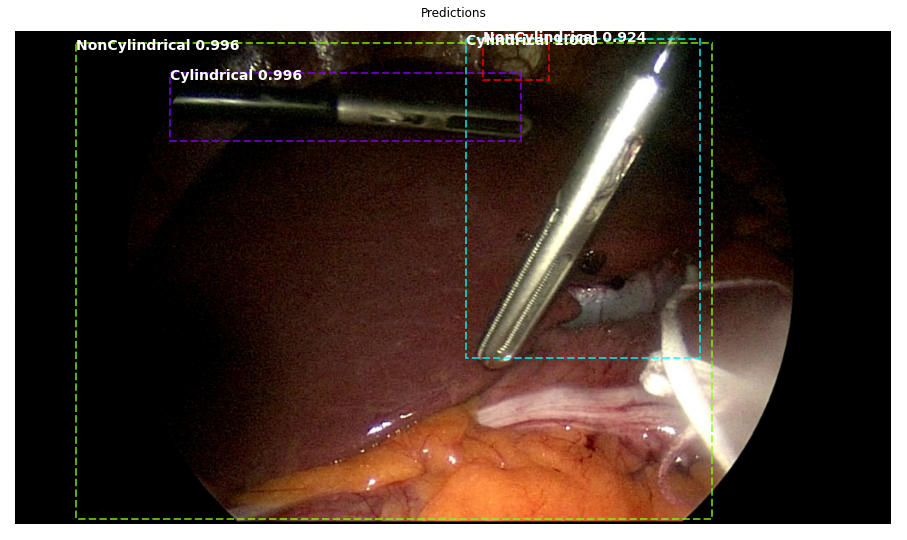

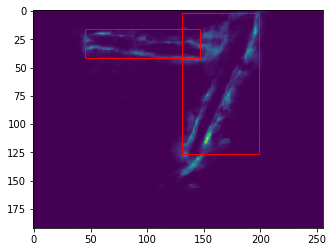

In [42]:

# Packages 
import matplotlib.patches as patches
import cv2
import skimage
import matplotlib.pyplot as plt
import numpy as np

path_multipe = '/home/mahmoud/Desktop/trocar_estimation/videoframes/multipletools/frame3127.jpg'


#................... ....................Predict Mask RCNN........................... 
# Plotting dependency 
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Load image
image = skimage.io.imread(path_multipe)
print(image.shape)

# If grayscale. Convert to RGB for consistency.
if image.ndim != 3:
    image = skimage.color.gray2rgb(image)

# If has an alpha channel, remove it for consistency
if image.shape[-1] == 4:
    image = image[..., :3]
orig_shape = image.shape

# resize image to be suitable for Mask RCNN 
image, window = modellib.loadExternalImage(image, config)

# Predict detection 
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

'''
# show original prediction withoud cropping the padding 
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions", show_mask=False)
'''


# padding params
y1 = int(window[0]) 
x1 = int(window[1])
y2 = int(window[2])
x2 = int(window[3])

# origimage without padding areas 
origimage = image[y1:y2, x1:x2]


for i in range(r['rois'].shape[0]):    
    # project bbox to original image coordinate frame 
    r['rois'][i][0] = r['rois'][i][0] - int((1024 - origimage.shape[0])/2)
    r['rois'][i][2] = r['rois'][i][2] - int((1024 - origimage.shape[0])/2)
    
    # adjust bbox to image border
    if r['rois'][i][2] > origimage.shape[1] : # y2
        r['rois'][i][2] = origimage.shape[1] - r['rois'][i][2]
    if r['rois'][i][3] > origimage.shape[1] : # x2
        r['rois'][i][3] = origimage.shape[1] - r['rois'][i][3]
        
    if r['rois'][i][0] < 0 :  # y1
        r['rois'][i][0] = 0
    if r['rois'][i][1] < 0 :   # x1
        r['rois'][i][1] = 0
    '''
    if r['rois'][i][0] < 0 :  # y1
        r['rois'][i][0] = 0
    if r['rois'][i][1] < 0 :   # x1
        r['rois'][i][1] = 0
    '''    
    

# save a copy of the found bounding boxes 
artnet_coords = r['rois'].copy()    
artnet_classids = r['class_ids'].copy()    

# show original image with results 
visualize.display_instances(origimage, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions", show_mask=False)



# ...............Read and resize image to be fed to ART-Net..................
imageArt = cv2.resize(cv2.imread(path_multipe),(256,192))
img=imageArt/imageArt.max()
img=np.expand_dims(img, axis=0)


# .................Predict ART-Net, edge lines: 3, tool masks : 0, .................
edgeL = 3
toolM = 0
midL = 1 
tip = 2
Prediction =modelArt.predict(img,verbose=1)
mask=(255*(Prediction[edgeL].reshape(192,256))).astype(np.uint8) 

imageRGB = cv2.cvtColor(imageArt, cv2.COLOR_BGR2RGB)

# Create figure and axes
fig, ax = plt.subplots()
# Display the image
ax.imshow(mask)

# count cylindrical tools 
count = 0
for i in range(artnet_coords.shape[0]):
    if dataset.class_names[artnet_classids[i]] == 'Cylindrical':
        count = count + 1 
# masks 
masksTemp = np.zeros((mask.shape[0],mask.shape[1],count),dtype=np.uint8)

#print('mask shape',masksTemp.shape)

#................... Start............
countCylind = 0
if artnet_coords.shape[0] == 0:
    print('No tool deteced...')
elif artnet_coords.shape[0] >= 1: 
    for i in range(artnet_coords.shape[0]):   #artnet_coords.shape[0]
        # check if the tool is cylindrical 
        if dataset.class_names[artnet_classids[i]] == 'Cylindrical':
            # represent bounding box with [x1,y1,x2,y2]
            x1 = artnet_coords[i][1] #- (origimage.shape[1] - 192)
            y1 = artnet_coords[i][0] #- (origimage.shape[0] - 256)
            x2 = artnet_coords[i][3] #- (origimage.shape[1] - 192)
            y2 = artnet_coords[i][2] #- (origimage.shape[0] - 256)
            
            # projcet bounding box to original image shape 
            if x1 != 0:
                x1 = (x1 / origimage.shape[1]) * imageRGB.shape[1] #- (origimage.shape[0] - 192)
            if y1 != 0:    
                y1 = (y1 / origimage.shape[0]) * imageRGB.shape[0] #- (origimage.shape[1] - 256)
            if x2 != 0:    
                x2 = (x2 / origimage.shape[1]) * imageRGB.shape[1] #- (origimage.shape[0] - 192)
            if y2 != 0:    
                y2 = (y2 / origimage.shape[0]) * imageRGB.shape[0] #- (origimage.shape[1] - 256)
              
            maskFilter = mask.copy()
            maskFilter[int(y1):int(y2), int(x1):int(x2)] = 0
            newmask = mask - maskFilter
            newmask[newmask>=20]=255

            # Extract geometric primitives 
            edgeLinesM(imageArt,newmask, countCylind, origimage)
            #midLineM(imageArt,newmask, countCylind, origimage)
            #tipPointM(imageArt,newmask, i)
            masksTemp[:,:,countCylind] = newmask
            ax.imshow(mask)
            countCylind = countCylind  + 1 
            # Create a Rectangle patch
            rect = patches.Rectangle((int(x1), int(y1)),  int(x2 - x1), int(y2 - y1), linewidth=1, edgecolor='r', facecolor='none')


            # Add the patch to the Axes
            ax.add_patch(rect)

        else:
            print('Non-Cylindrical tool detected..')
            

#print(masksTemp.shape)
'''
print(np.unique(masksTemp))
masksTemp[:,:,1][masksTemp[:,:,1]>50]=255
masksTemp[:,:,0][masksTemp[:,:,0]>50]=255   
masksTemp[:,:,2][masksTemp[:,:,2]>50]=255


img1 = cv2.cvtColor(masksTemp[:,:,1], cv2.COLOR_GRAY2BGR)
img1[np.where((img1==[255, 255, 255]).all(axis=2))] = [255, 0, 0]
img2 = cv2.cvtColor(masksTemp[:,:,0], cv2.COLOR_GRAY2BGR)
img2[np.where((img2==[255, 255, 255]).all(axis=2))] = [0, 255, 0]
img3 = cv2.cvtColor(masksTemp[:,:,2], cv2.COLOR_GRAY2BGR)
img3[np.where((img2==[255, 255, 255]).all(axis=2))] = [255, 255, 255]
img = cv2.bitwise_or(img1, img2)
imgF = cv2.bitwise_or(img, img3)
    
    

'''


            



        
#plt.imshow(mask)
#plt.imshow(imgF)
#plt.imshow(masksTemp[:,:,0])
#plt.show()
